In [6]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from src.bioreactor import *

In [2]:
# Check if ../models/simple_nn.pkl exists
# If it does, load the model; if not, train the model and save it
try:
    model = pickle.load(open('./models/simple_nn.pkl', 'rb'))
except FileNotFoundError:
    X_train, y_train = generate_training_data()

    model = MLPRegressor(hidden_layer_sizes=(256,256), learning_rate='adaptive',  
                        learning_rate_init=0.001, max_iter=1000, tol=1e-6, activation='relu', 
                        batch_size=256, early_stopping=True, verbose=True)   
    model.fit(X_train, y_train)
    pickle.dump(model, open('./models/simple_nn.pkl', 'wb'))

In [3]:
X, S, V, F = mpc(model='discretized')
# X, S, V, F = mpc_pso(model)
# X, S, V, F = mpc_diff_evol(model)
# X, S, V, F = mpc(model)

 28%|██▊       | 112/400 [00:05<00:39,  7.35it/s]

 30%|███       | 121/400 [00:09<01:13,  3.82it/s]

 35%|███▌      | 140/400 [00:11<00:29,  8.85it/s]

 38%|███▊      | 152/400 [00:13<01:00,  4.10it/s]

 42%|████▏     | 166/400 [00:14<00:24,  9.38it/s]

 45%|████▌     | 180/400 [00:14<00:11, 18.97it/s]

 48%|████▊     | 191/400 [00:15<00:11, 18.80it/s]

 48%|████▊     | 194/400 [00:15<00:10, 18.98it/s]

 49%|████▉     | 197/400 [00:16<00:21,  9.47it/s]

 51%|█████     | 204/400 [00:16<00:15, 13.00it/s]

 55%|█████▌    | 221/400 [00:17<00:08, 21.65it/s]

 61%|██████▏   | 245/400 [00:17<00:04, 37.06it/s]

 64%|██████▍   | 256/400 [00:18<00:03, 40.91it/s]

 72%|███████▎  | 290/400 [00:18<00:01, 73.37it/s]

100%|██████████| 400/400 [00:19<00:00, 20.76it/s] 


Maximum biomass concentration: 76.82 g/l at time 38.00 hours


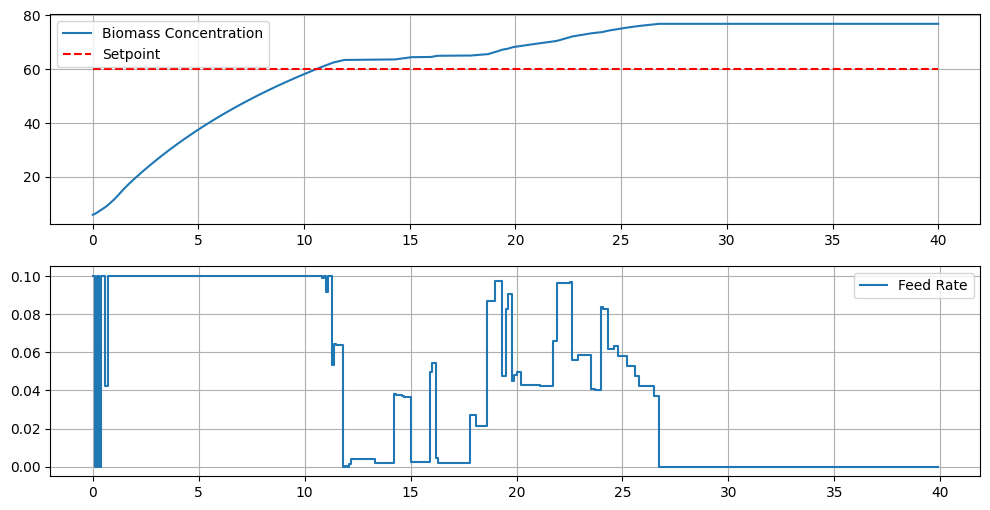

In [7]:
plot_results(X, F)

In [11]:
def Fs(t: float, experiment: str = 'BR07') -> float:
    conditions = {
        'BR02': [(3.4, 8, 0.013, 0.0001)],
        'BR03': [(4.8, 9.3, 0.011, 0.0006)],
        'BR04': [(4.45, 9, 0.006, 0.00005)],
        'BR05': [(5.6, 9.1, 0.006, 0.00005)],
        'BR06': [(4.3, 9, 0.013, 0.0003)],
        'BR07': [(3.9, 9, 0.01, 0.0002)],
        'BR08': [(3.6, 10, 0.01, 0.0002)]
    }
    
    if experiment in conditions:
        start, end, slope1, slope2 = conditions[experiment][0]
        if t <= start:
            return 0
        elif start < t <= end:
            return slope1 * t + 0.0015
        else:
            return slope2 * t + 0.0015
    return 0



Maximum biomass concentration: 40.59 g/l at time 40.00 hours


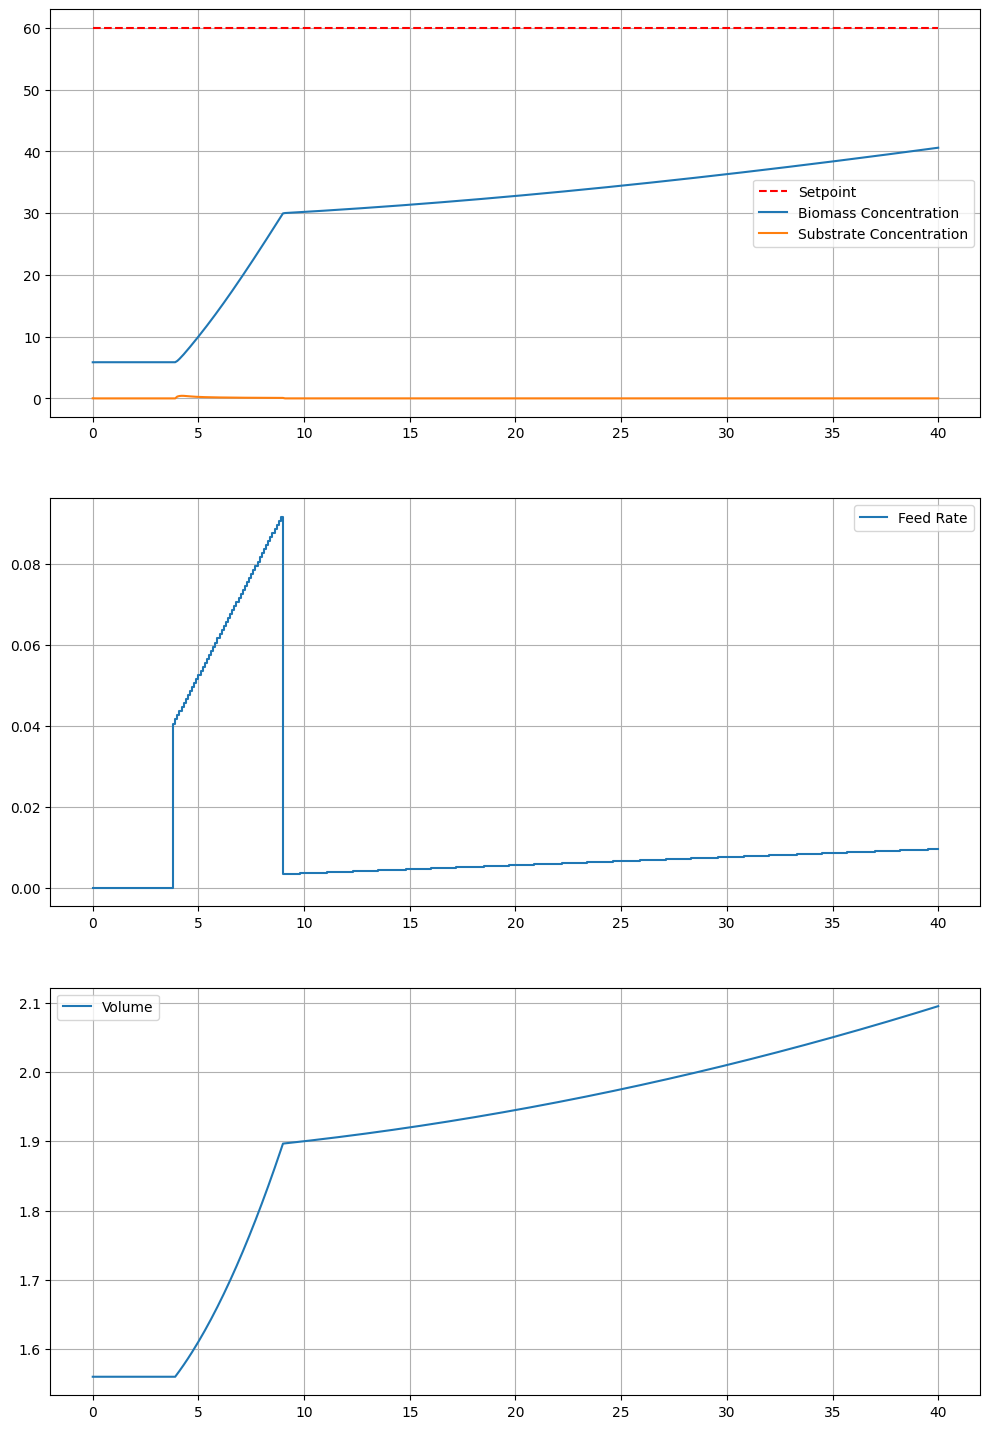

In [15]:
evaluation(Fs)